In [1]:
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import multivariate_normal as mvn
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from math import log, exp, sqrt, sin, cos, pi, pow
%matplotlib inline

p = np.array([1, 1])
c = np.array([[0.13287857, -0.12345357], [-0.12345357, 0.19375536]])
# c = np.array([[1.3287857, -1.2345357], [-1.2345357, 1.9375536]])

reg_sum, app_sum = 0, 0

cx, cy, res = 1.0, 1.0, 2.0
r = 0.1
x, y = np.arange(cx-res/2, cx+res/2, r), np.arange(cy-res/2, cy+res/2, r)
for i in x:
    for j in y:
        reg_sum += mvn(p, c).pdf([i, j]) * (r ** 2)
print(reg_sum)

# Appromimate
rej = 0.1
c0 = (2 * pi) * sqrt(np.linalg.det(c))
c1 = (1.0 - rej) / c0
c2 = rej / pow(res, 2)
for i in x:
    for j in y:
        q = np.array([i, j]) - p
        app_sum += (c1 * exp(-0.5 * q.dot(np.linalg.inv(c).dot(q))) + c2) * (r ** 2)
print('simulated c1 = {:.4f}, c2 = {:.4f}'.format(c1, c2))
print(app_sum)

In /home/ee904/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ee904/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ee904/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ee904/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ee904/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

0.9730902882921539
simulated c1 = 1.3975, c2 = 0.0250
0.9757812594629376


(-0.5, 3.0)

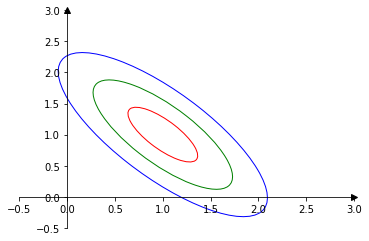

In [2]:
def ell(xy, cov, ax, n_std, facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(xy[0], xy[1])
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ell(p, c, ax, 1, edgecolor='r', label='$p - q\;(1\sigma)$')
ell(p, c, ax, 2, edgecolor='g', label='$p - q\;(2\sigma)$')
ell(p, c, ax, 3, edgecolor='b', label='$p - q\;(3\sigma)$')
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)

In [28]:
def linep(x, mean, std, c1, c2):
    return [c1 * exp(-0.5 * ((i - mean) / std) ** 2) + c2 for i in x]

def tildep(x, mean, std, c1, c2):
    d3 = -log(c2)
    d1 = -log(c1 + c2) - d3
    d2 = -2 * log((-log(c1 * exp(-0.5) + c2) - d3) / d1)
    print(d1, d2, d3)
    return [d1 * exp(-0.5 * d2 * ((i - mean) / std) ** 2) + d3 for i in x]


def draw(rej, cs):
    fig = plt.figure(figsize=(14, 6))
    x_min, x_max = 0, 20
    mean, std = 10.0, 1.5

    c0 = sqrt(2 * pi) * std
    c1 = (1.0 - rej) / c0
    c2 = rej / cs
# T c1 = (1. - outlier_ratio_) / (2 * M_PI * cq.inverse().determinant());
#       T d3 = -ceres::log(c2);
#       T d1 = -ceres::log(c1 + c2) - d3;
#       T d2 = -T(2) * ceres::log((-ceres::log(c1 * ceres::exp(-0.5) + c2) - d3) / d1);
    ax = fig.add_subplot(121)
    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x, mean, std)
    y2 = linep(x, mean, std, c1, c2)
    y3 = tildep(x, mean, std, c1, c2)
    ax.plot(x, y, 'b', label='$p(x)$')
    ax.plot(x, y2, 'g', label='$\overline{p}(x)$')
    ax.grid()
    ax.legend()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 0.35)

    ax = fig.add_subplot(122)
    ax.plot(x, [-log(i) for i in y], 'b', label='$-\log(p(x))$')
    ax.plot(x, [-log(i) for i in y2], 'g', label='$-\log(\overline{p}(x))$')
    ax.plot(x, y3, 'r', label='$\widetilde{p}(x)$')
    y3 = tildep(x, mean, std, c1, c2)
    ax.grid()
    ax.legend()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 10)

-1.0968478669936663 0.648931033617935 2.5257286443082556
-1.0968478669936663 0.648931033617935 2.5257286443082556


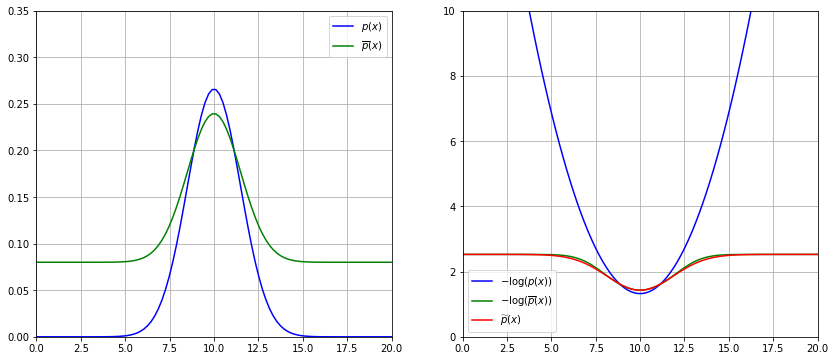

In [29]:
draw(0.4, 5)

-2.5625054822483984 0.38734593264466993 3.912023005428146
-2.5625054822483984 0.38734593264466993 3.912023005428146


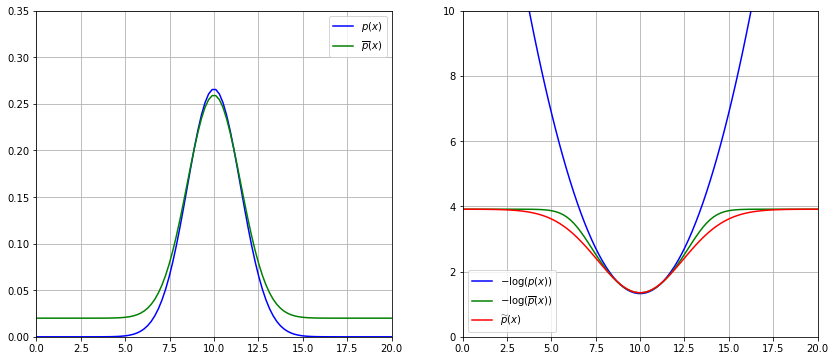

In [30]:
draw(0.1, 5)

-4.887721261353088 0.21360987663252082 6.214608098422191
-4.887721261353088 0.21360987663252082 6.214608098422191


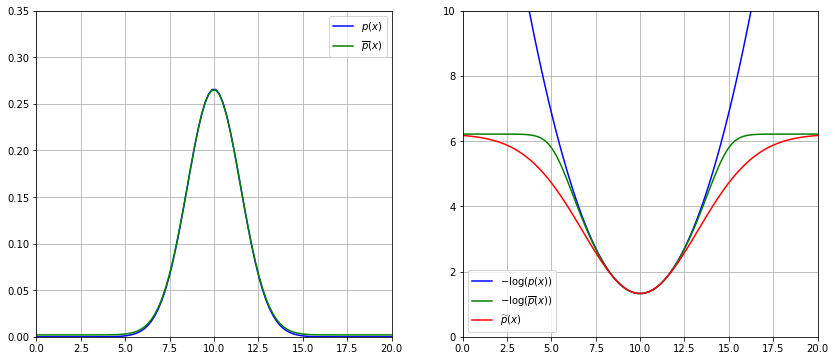

In [31]:
draw(0.01, 5)